In [217]:
#load libraries
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os as os

In [289]:
#Loop to read in data and make dataframes

march_path="./data/march_april/"
april_path="./data/april_may/"

march_file_list=[file for file in os.listdir(march_path) if file.endswith('.csv')]

april_file_list=[file for file in os.listdir(april_path) if file.endswith('.csv')]

#function to check if march and april lists are identical
def compare_lists(list1,list2):
    if len(list1) != len(list2):
        return False
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            return False
    return True


#loop to read files
dataframes_dict={}
if compare_lists(march_file_list,april_file_list)==True:
    for i in range(len(march_file_list)):
        dataframes_dict[march_file_list[i][:len(march_file_list[i])-4]]=pd.concat([pd.read_csv(march_path+march_file_list[i]),pd.read_csv(april_path+april_file_list[i])])
else: 
    print(f"Check to see if the same number of files are in each directory and if the names are the same.  compare= {compare_lists(march_file_list,april_file_list)}")                                                                                                


In [290]:
#get intensity data
#load the dataframe
df_intensity_minute=dataframes_dict['minuteIntensitiesNarrow_merged'].copy()

#convert ActivityMinute to date time and extract the date
df_intensity_minute["ActivityMinute"]=pd.to_datetime(df_intensity_minute["ActivityMinute"],format='%m/%d/%Y %I:%M:%S %p')
df_intensity_minute["date"]=df_intensity_minute["ActivityMinute"].dt.strftime('%Y-%m-%d')

#remove duplicates (some of the 4/12 data is in both files)
df_intensity_minute=df_intensity_minute.drop_duplicates()

#Remove rows where Intensity is 0 (0 is resting)
df_intensity_day=df_intensity_minute[df_intensity_minute["Intensity"] !=0]

#drop the ActivityMinute column and group by Id and date
df_intensity_day=df_intensity_day.drop(columns=["ActivityMinute"])
df_intensity_day=df_intensity_day.groupby(by=["Id","date"]).agg(intensity_minutes=("Intensity","count")).reset_index()

df_intensity_day.info()
display(df_intensity_day.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688 entries, 0 to 1687
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id                 1688 non-null   int64 
 1   date               1688 non-null   object
 2   intensity_minutes  1688 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 39.7+ KB


,Id,date,intensity_minutes
1683,8877689391,2016-05-08,266
1684,8877689391,2016-05-09,309
1685,8877689391,2016-05-10,253
1686,8877689391,2016-05-11,313
1687,8877689391,2016-05-12,141


In [369]:
#get sleep data
#load the dataframe
df_sleep_minute=dataframes_dict['minuteSleep_merged'].copy()

#convert date to date time, extract the date
df_sleep_minute["date"]=pd.to_datetime(df_sleep_minute["date"],format='%m/%d/%Y %I:%M:%S %p')
df_sleep_minute["date2"]=df_sleep_minute["date"].dt.strftime('%Y-%m-%d')

#remove duplicates (some of the 4/12 data is in both files)
df_sleep_minute=df_sleep_minute.drop_duplicates()

#find max date because logId spans midnight
df_max_date_logid=df_sleep_minute.groupby(by=["logId"]).agg(
    max_date=("date2","max")).reset_index()

#merge in max date with sleep data
df_sleep_minute=pd.merge(df_sleep_minute,df_max_date_logid,
                      how="left",
                      on="logId")


#group and aggregate
df_sleep_day=df_sleep_minute.groupby(by=["Id","logId"]).agg(
    sleep_minutes=("value","count"),
    date=("max_date","max")).reset_index()

#drop logId column amd reorder
df_sleep_day=df_sleep_day.drop(columns=["logId"])
df_sleep_day=df_sleep_day[["Id","date","sleep_minutes"]]

df_sleep_day
 

,Id,date,sleep_minutes
0,1503960366,2016-03-13,426
1,1503960366,2016-03-14,386
2,1503960366,2016-03-15,335
3,1503960366,2016-03-16,303
4,1503960366,2016-03-16,63
...,...,...,...
1002,8792009665,2016-04-30,360
1003,8792009665,2016-05-01,527
1004,8792009665,2016-05-02,423
1005,8792009665,2016-05-03,545


In [370]:
#merge intensity and sleep data
df_intensity_sleep_day=pd.merge(df_intensity_day,df_sleep_day,
                                how="inner",
                                on=["Id","date"]
                                )

df_intensity_sleep_day.info()
display(df_intensity_sleep_day.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id                 1006 non-null   int64 
 1   date               1006 non-null   object
 2   intensity_minutes  1006 non-null   int64 
 3   sleep_minutes      1006 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 31.6+ KB


,Id,date,intensity_minutes,sleep_minutes
0,1503960366,2016-03-13,334,426
1,1503960366,2016-03-14,298,386
2,1503960366,2016-03-15,403,335
3,1503960366,2016-03-16,318,303
4,1503960366,2016-03-16,318,63


,intensity_minutes,sleep_minutes
intensity_minutes,1.000000,-0.002819
sleep_minutes,-0.002819,1.000000


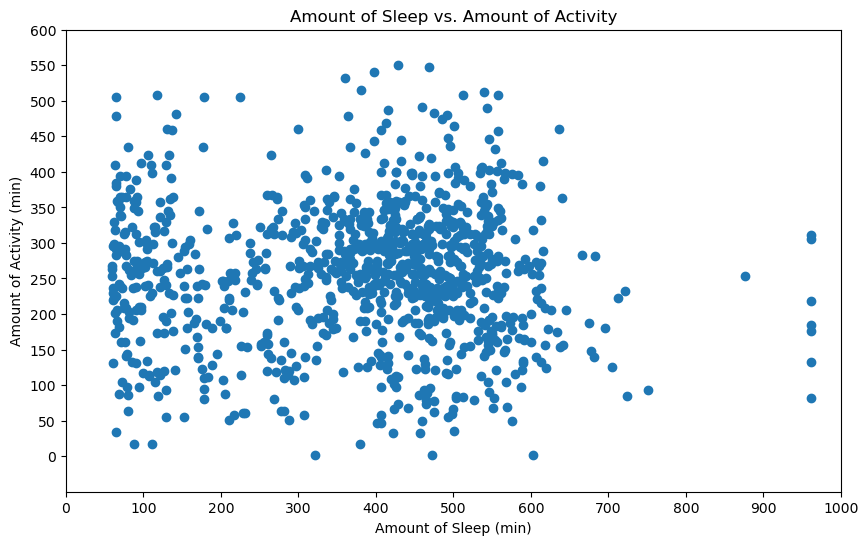

In [371]:
#find correlation coefficients
display(df_intensity_sleep_day[["intensity_minutes","sleep_minutes"]].corr())

#plot
fig1, ax1=plt.subplots(figsize=(10,6))
ax1.scatter(x=df_intensity_sleep_day["sleep_minutes"], y=df_intensity_sleep_day["intensity_minutes"])
ax1.set_yticks(ticks=range(0,650,50))
ax1.set_ylim(-50,600)
ax1.set_xticks(ticks=range(0,1100,100))
ax1.set_xlim(0,1000)
ax1.set_xlabel("Amount of Sleep (min)")
ax1.set_ylabel("Amount of Activity (min)")
ax1.set_title("Amount of Sleep vs. Amount of Activity")
plt.show()

In [387]:
#outliers
quartiles=df_intensity_sleep_day["sleep_minutes"].quantile([0.25,0.5,0.75])
lowerq=quartiles[0.25]
upperq=quartiles[0.75]
iqr=upperq-lowerq
lower_bound=lowerq-(1.5*iqr)
upper_bound=upperq+(1.5*iqr)

print(quartiles)
print(iqr)
print(f"The lower bound for sleep minutes is {lower_bound}")
print(f"The upper bound for sleep minutes is {upper_bound}")




0.25    266.25
0.50    416.50
0.75    496.00
Name: sleep_minutes, dtype: float64
229.75
The lower bound for sleep minutes is -78.375
The upper bound for sleep minutes is 840.625


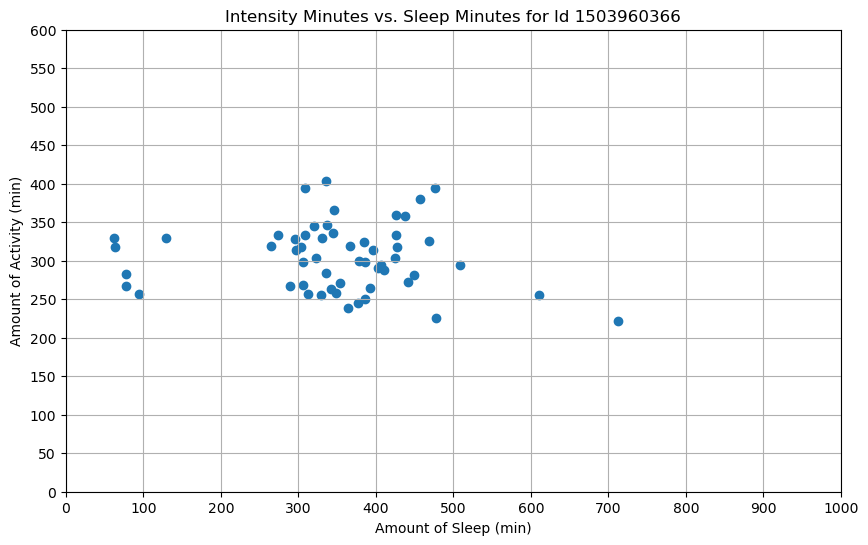

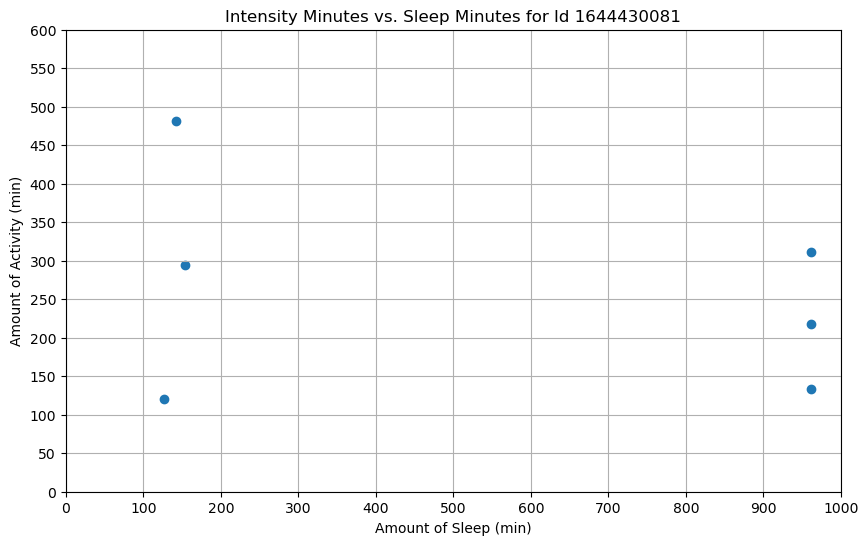

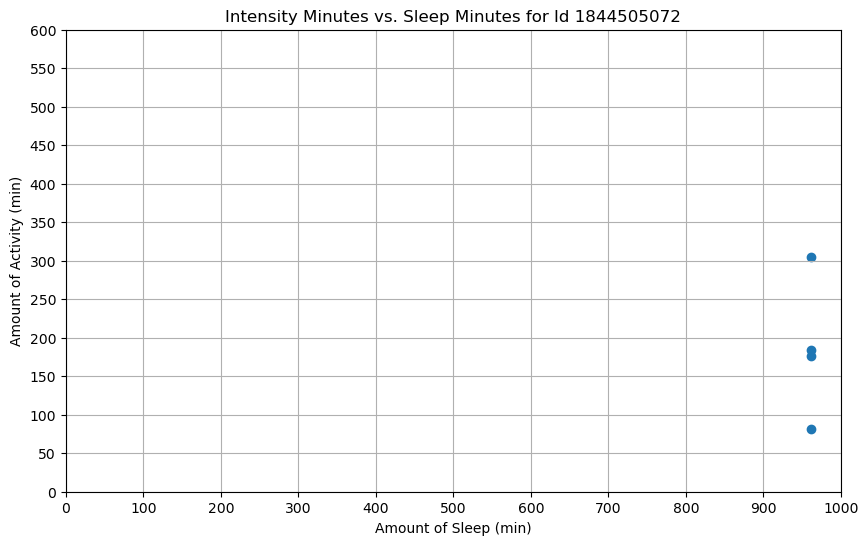

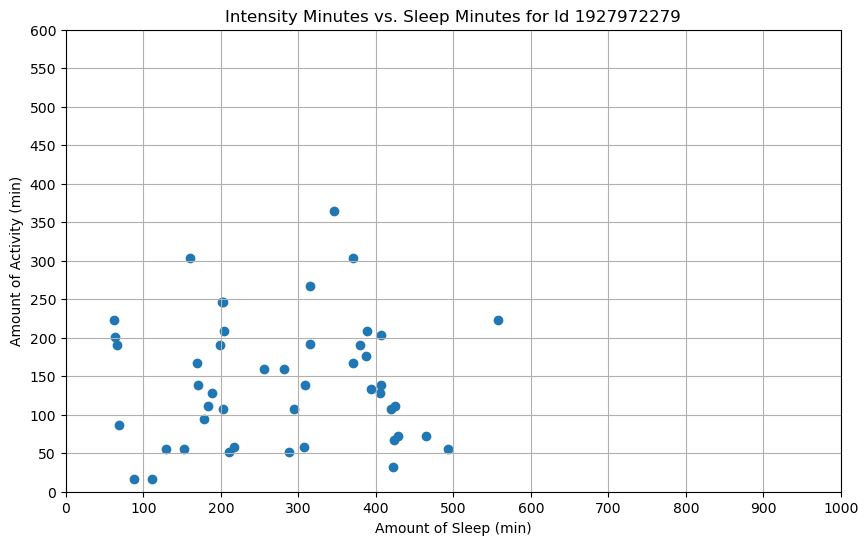

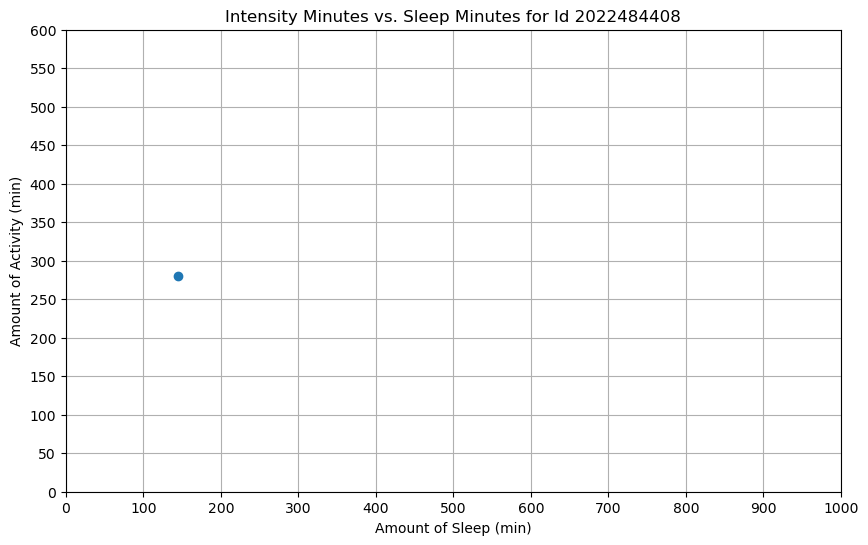

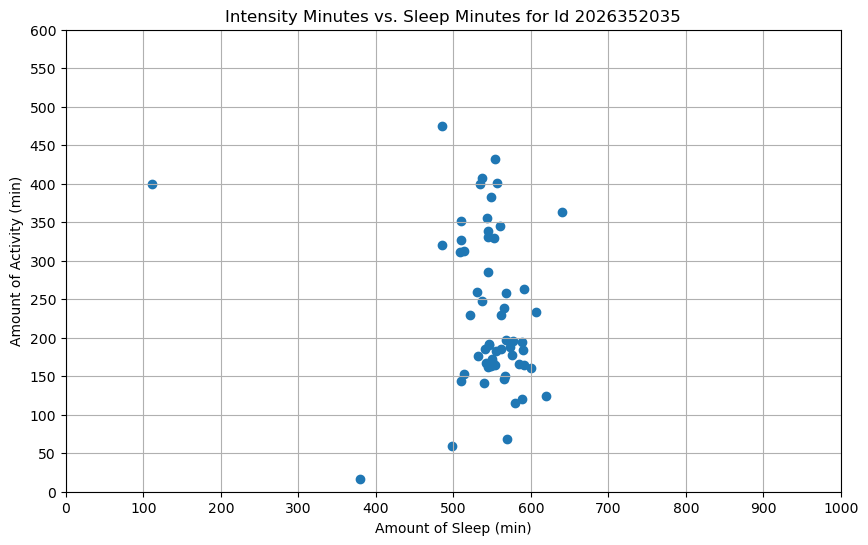

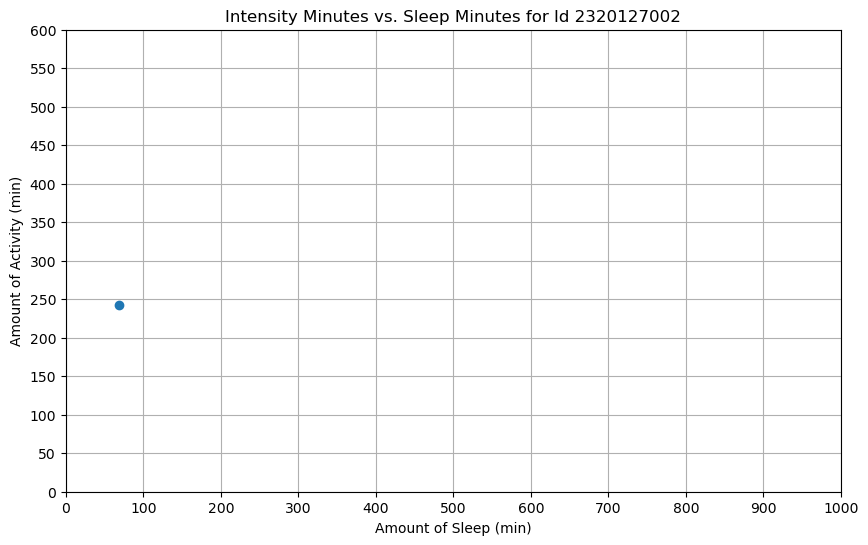

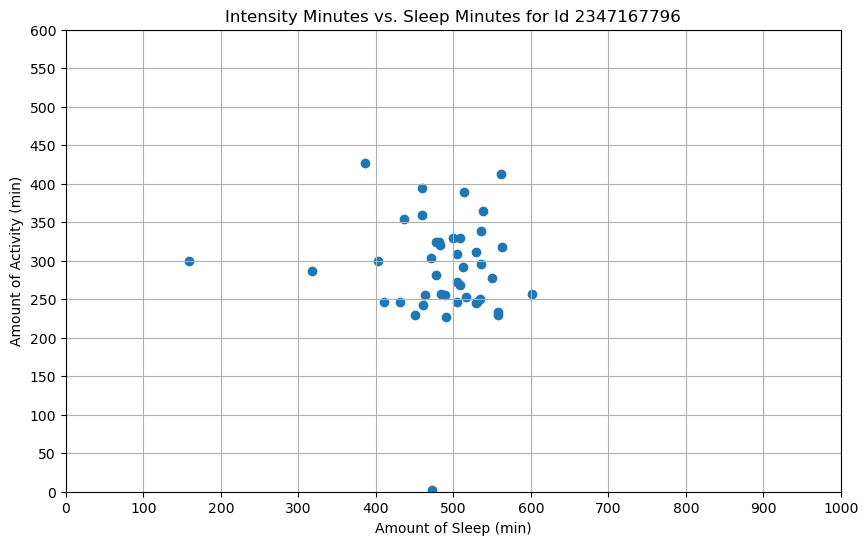

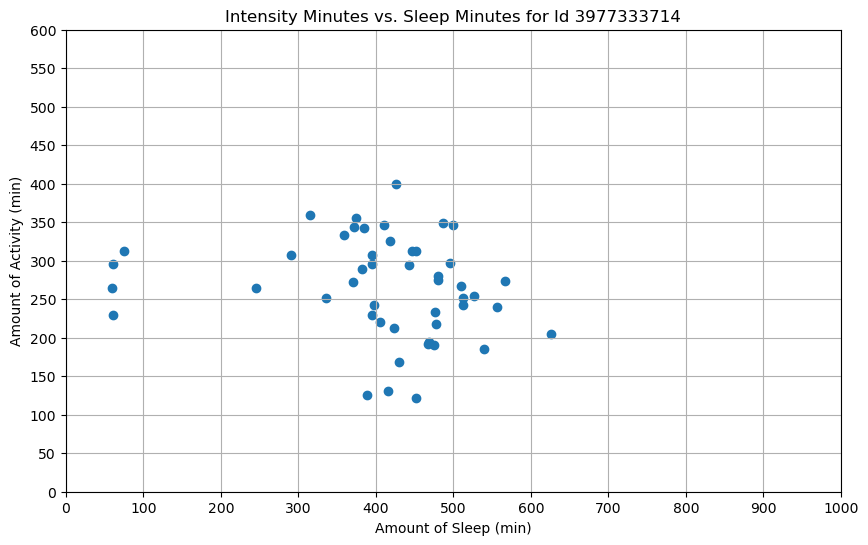

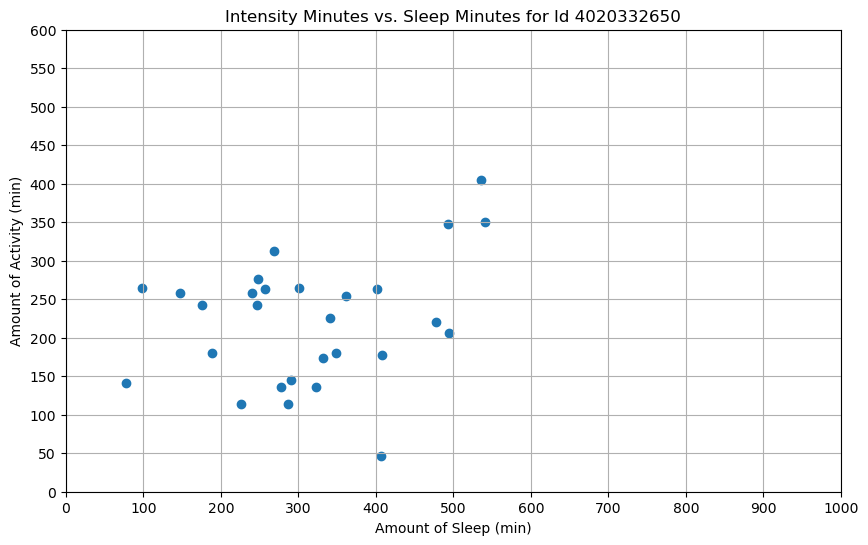

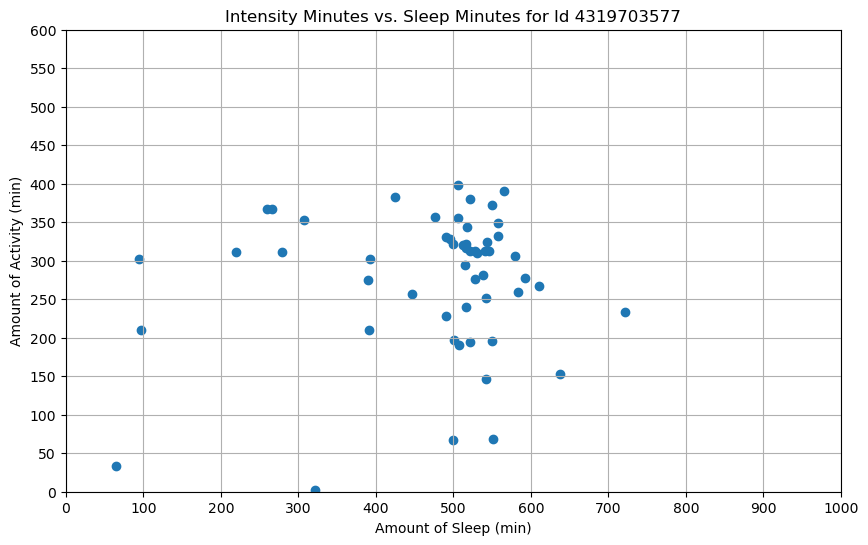

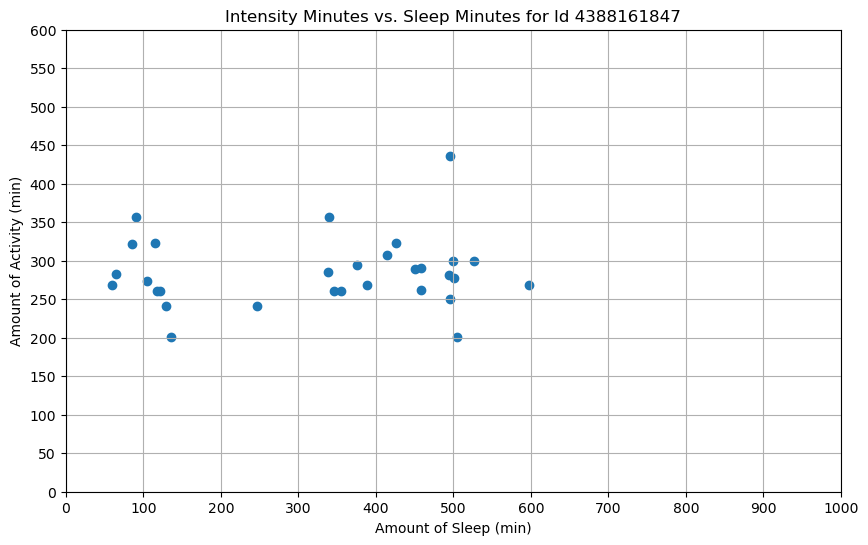

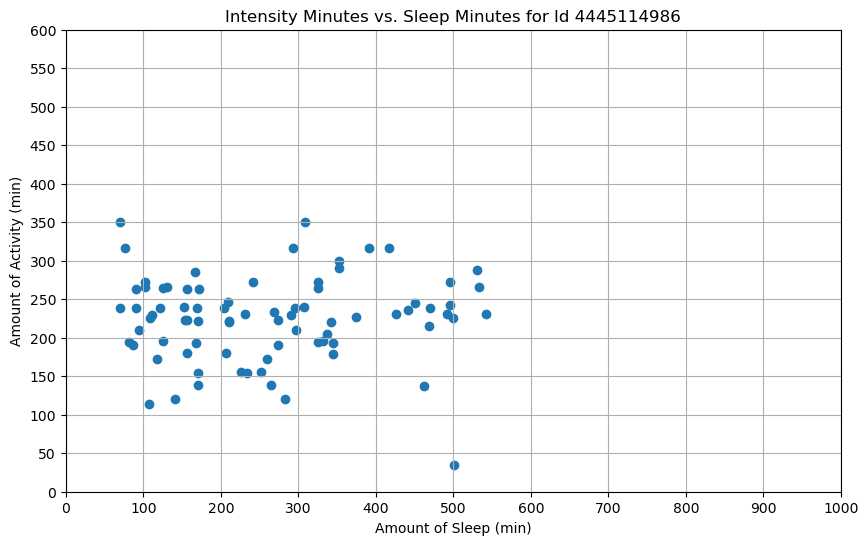

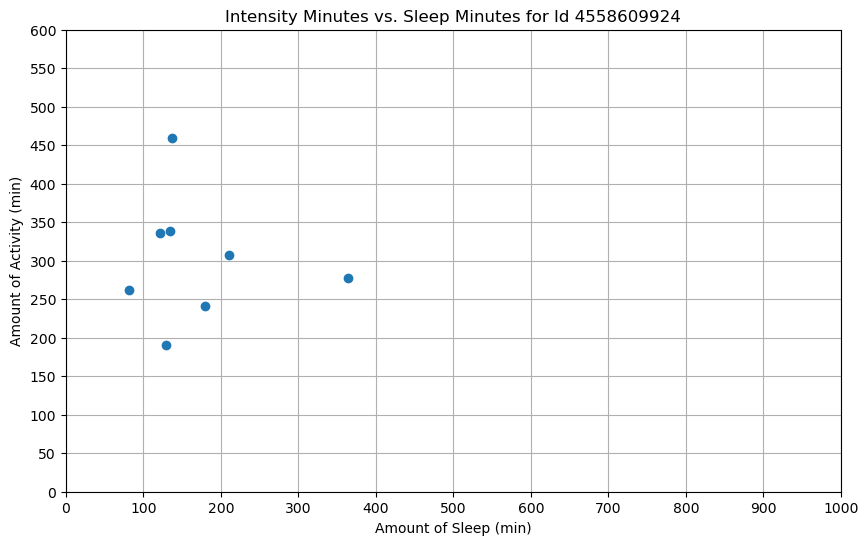

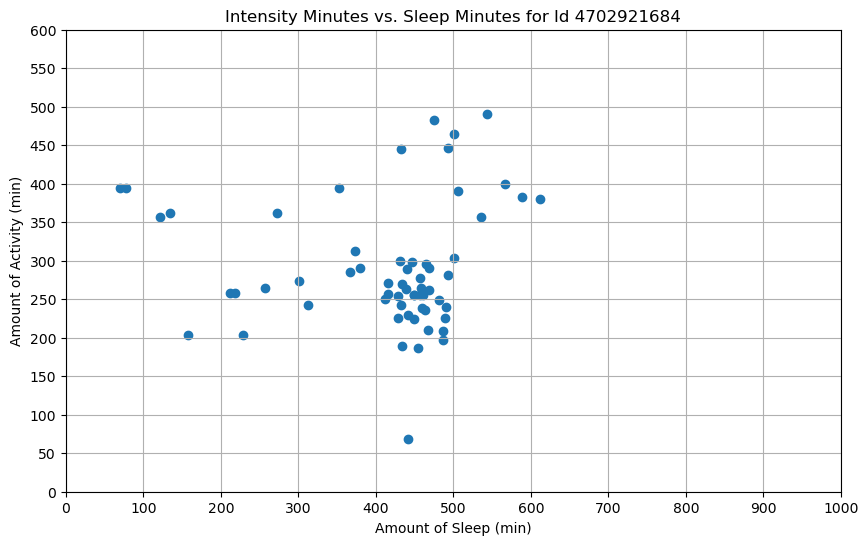

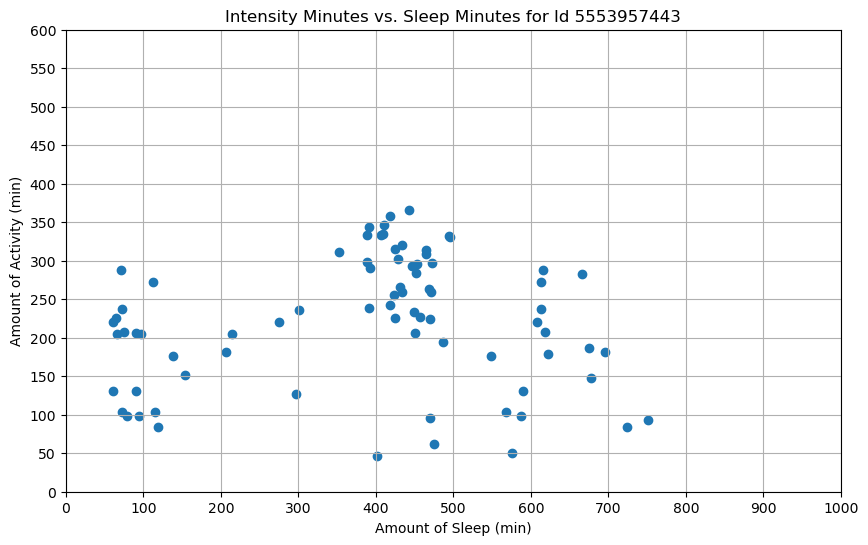

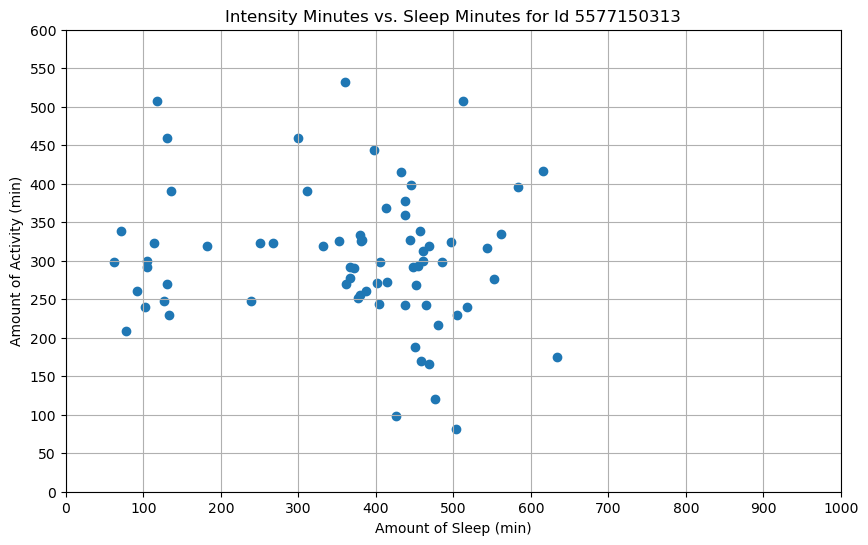

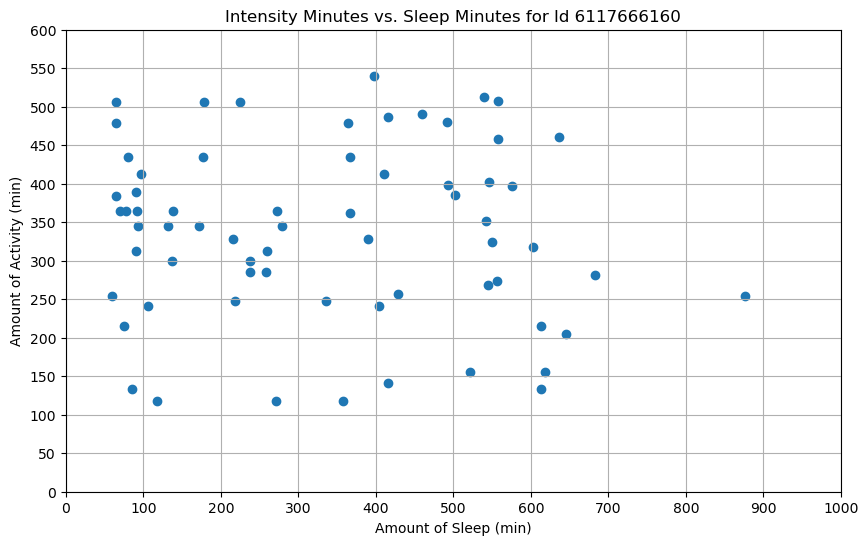

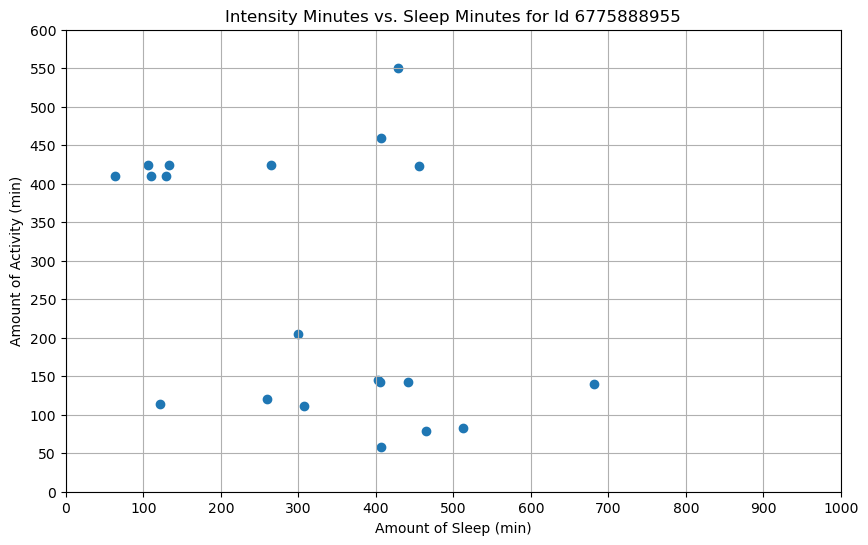

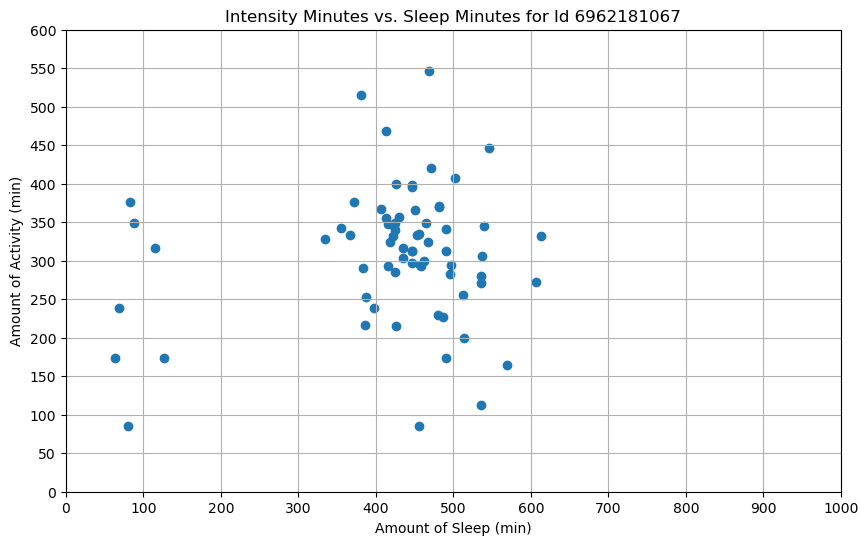

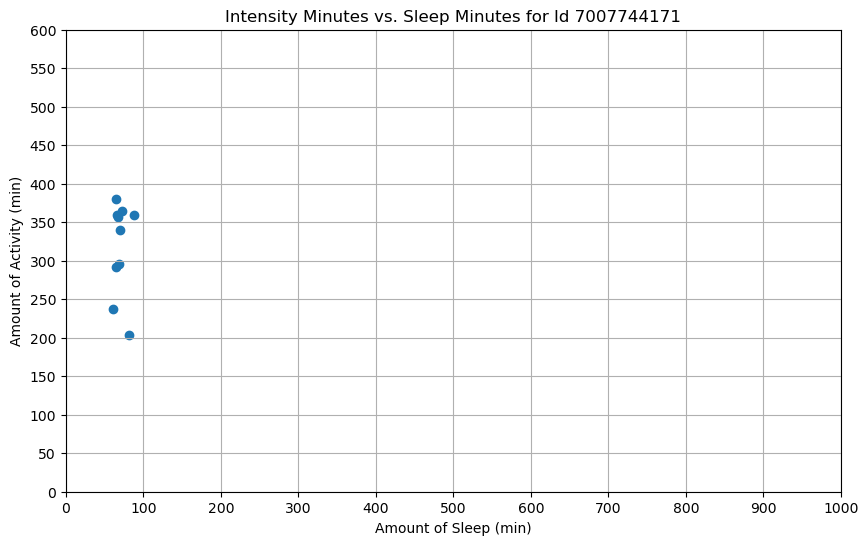

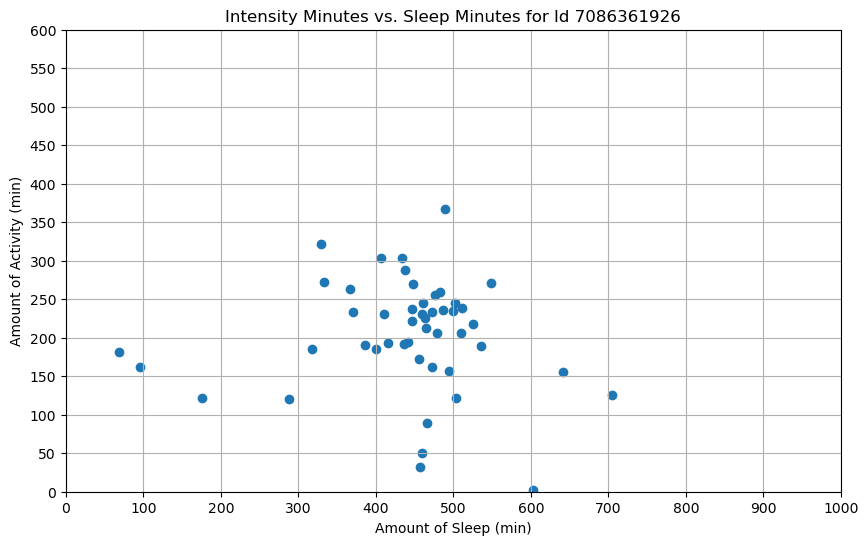

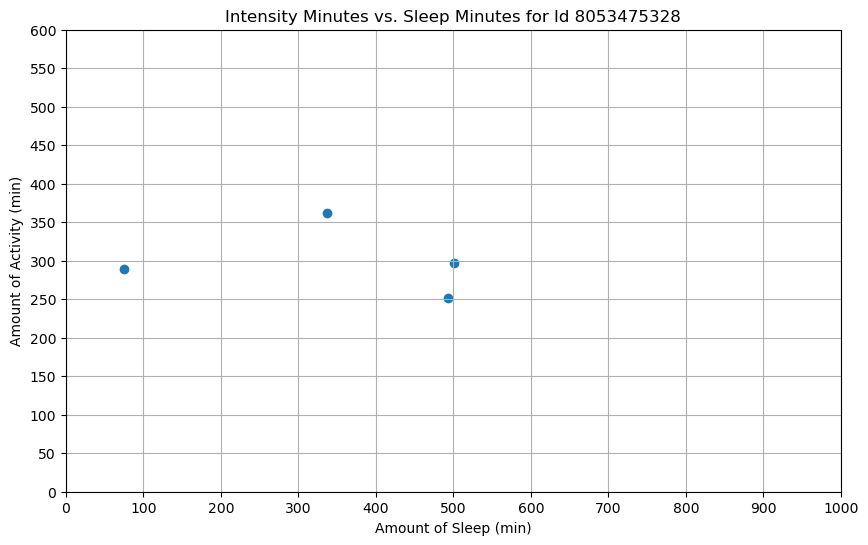

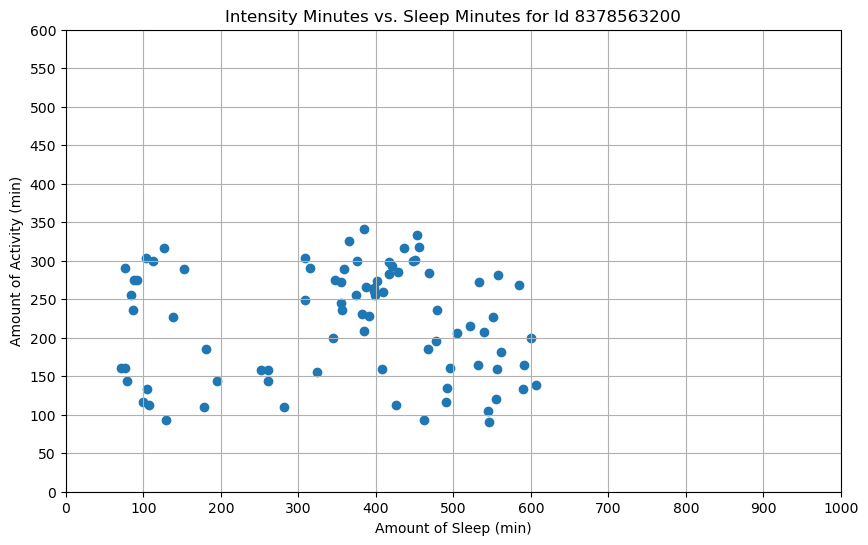

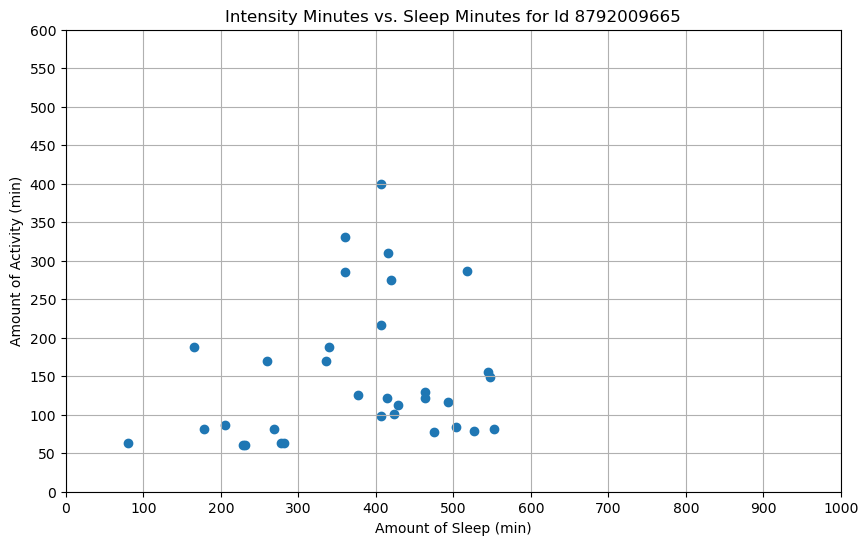

In [372]:
#plot individual plots
#plot
unique_ids=df_intensity_sleep_day["Id"].unique()

for id in unique_ids:
    plt.figure(figsize=(10,6))
    subset=df_intensity_sleep_day[df_intensity_sleep_day["Id"]==id]
    plt.scatter(subset["sleep_minutes"], subset["intensity_minutes"])
    plt.xlim(0,1000)
    plt.xticks(range(0,1001,100))
    plt.ylim(0,600)
    plt.yticks(range(0,601,50))
    plt.xlabel("Amount of Sleep (min)")
    plt.ylabel("Amount of Activity (min)")
    plt.title(f'Intensity Minutes vs. Sleep Minutes for Id {id}')
    plt.grid(True)
    plt.show()

In [ ]:
fig1, ax1=plt.subplots(figsize=(15,6))

for key, grp in df_intensity_sleep_day.groupby(["Id"]):
    ax1.scatter(x=df_intensity_sleep_day["sleep_minutes"], y=df_intensity_sleep_day["intensity_minutes"], label=key)
ax1.set_xlabel("Amount of Sleep (min)")
ax1.set_ylabel("Amount of Activity (min)")
ax1.set_title("Amount of Sleep vs. Amount of Activity")
plt.legend(title="Id")
plt.show()

In [ ]:
#get sleep data
#load the dataframe
df_sleep_minute=dataframes_dict['minuteSleep_merged'].copy()

#convert date to date time, extract the date
df_sleep_minute["date"]=pd.to_datetime(df_sleep_minute["date"],format='%m/%d/%Y %I:%M:%S %p')
df_sleep_minute["date2"]=df_sleep_minute["date"].dt.strftime('%Y-%m-%d')

#remove duplicates (some of the 4/12 data is in both files)
df_sleep_minute=df_sleep_minute.drop_duplicates()

#group and aggregate, need max date because logId spans midnight and want to identify with morning woke up
df_sleep_day=df_sleep_minute.groupby(by=["Id","date2","logId"]).agg(
    sleep_minutes=("value","count"),
    max_date=("date2","max")).reset_index()

#drop logId columns, rename max_date, re-order
#df_sleep_day=df_sleep_day.drop(columns=["logId"])
#df_sleep_day=df_sleep_day.rename(columns={"max_date":"date"})
#df_sleep_day=df_sleep_day[["Id","date","sleep_minutes"]]

df_sleep_day.info()
display(df_sleep_day[df_sleep_day["Id"]==5577150313])
